In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from utils.imports import *
from input_fn import input_fn
from cvt2tfrecord import fn_record_to_count
from utils.clr import LRFinder, OneCycleLR

# from tensorflow.keras.layers import *
# import tensorflow.keras as keras
# from tensorflow.keras import backend as K
# from tensorflow.keras.models import Model

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # "0, 1" for multiple

In [1]:
from models.model_factory import ModelType

In [4]:
# from utils.transforms import *
PATH = Path('../data')
sz = 128
# sz = 256
nt = 10
bs = 12
MODEL_VERSION = 'prednet_' + str(sz) + '_1'
MODEL_PATH = PATH/'models'

num_gpus = 1

# class Slice(Transform):
#     """ Return a slice of the images
    
#     Arguments:
#     The same as the built-in function slice
#     """
#     def __init__(self, *args, **kwargs):
#         self.slice = slice(*args, **kwargs)
#         super().__init__(TfmType.NO)
        
#     def do_transform(self, x, is_y):
#         return x[self.slice]

# aug_tfms = [Slice(nt)]
aug_tfms = []

In [5]:
from models.prednet_refactored import PredNetCell, PredNet

# n_channels, im_height, im_width = (3, 128, 160)
n_channels, im_height, im_width = (1, sz, sz)
input_shape = (im_height, im_width, n_channels)
stack_sizes = (n_channels, 48, 96, 192)
R_stack_sizes = stack_sizes
A_filt_sizes = (3, 3, 3)
Ahat_filt_sizes = (3, 3, 3, 3)
R_filt_sizes = (3, 3, 3, 3)

layer_loss_weights = np.array([1., 0., 0., 0.])  # weighting for each layer in final loss; "L_0" model:  [1, 0, 0, 0], "L_all": [1, 0.1, 0.1, 0.1]
layer_loss_weights = np.expand_dims(layer_loss_weights, 1)
time_loss_weights = 1./ (nt - 1) * np.ones((nt,1))  # equally weight all timesteps except the first
time_loss_weights[0] = 0

prednet_cell = PredNetCell(stack_sizes=stack_sizes,
                    R_stack_sizes=R_stack_sizes,
                    A_filt_sizes=A_filt_sizes,
                    Ahat_filt_sizes=Ahat_filt_sizes,
                    R_filt_sizes=R_filt_sizes)

prednet = PredNet(prednet_cell)

In [6]:
from tensorflow.keras.layers import TimeDistributed, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

inputs = tf.keras.Input(shape=(nt,) + input_shape)
errors = prednet(inputs)  # errors will be (batch_size, nt, nb_layers) 
errors_by_time = TimeDistributed(Dense(1, trainable=False), weights=[layer_loss_weights, np.zeros(1)], trainable=False)(errors)  # calculate weighted error by layer
errors_by_time = Flatten()(errors_by_time)  # will be (batch_size, nt)
final_errors = Dense(1, weights=[time_loss_weights, np.zeros(1)], trainable=False)(errors_by_time)  # weight errors by time
model = Model(inputs=inputs, outputs=final_errors)
# model = tf.keras.utils.multi_gpu_model(model, gpus=2)
optimizer = 'adam'
optimizer = 'sgd'
optimizer = SGD(lr=0.002, momentum=0.9, nesterov=True)
model.compile(loss='mean_absolute_error', optimizer=optimizer)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10, 128, 128, 1)   0         
_________________________________________________________________
pred_net (PredNet)           (None, 10, 4)             6909818   
_________________________________________________________________
time_distributed (TimeDistri (None, 10, 1)             5         
_________________________________________________________________
flatten (Flatten)            (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 6,909,834
Trainable params: 6,909,818
Non-trainable params: 16
_________________________________________________________________


In [7]:
fns = ['../data/tfrecords/train_1_contiguous_10']
val_split = 0.1
num_parallel_calls=32
buffer_size = 3
x, y, num_samples             = input_fn(bs, sz, nt, aug_tfms, fns, is_val=False, val_split=val_split,
                                         stats_fn='stat.csv', stats_sep=',', num_parallel_calls=num_parallel_calls, shuffle=True,
                                         buffer_size=buffer_size)
val_x, val_y, val_num_samples = input_fn(bs, sz, nt, aug_tfms, fns, is_val=True, val_split=val_split,
                                         stats_fn='stat.csv', stats_sep=',', num_parallel_calls=num_parallel_calls, shuffle=False,
                                         buffer_size=buffer_size)
# num_iterations is pre-batch iterations

In [8]:
# general training configs
path_checkpoints = MODEL_PATH/'checkpoints'
path_lrs = MODEL_PATH/'lrs'/MODEL_VERSION
if not path_checkpoints.exists(): path_checkpoints.mkdir(parents=True)
model_callbacks = [
    # TODO: save info of prednet cell
    tf.keras.callbacks.TensorBoard(),
#     keras.callbacks.History(),
#     tf.keras.callbacks.ModelCheckpoint(str(path_checkpoints/('weights.' + MODEL_VERSION + '.{epoch:02d}-{val_loss:.2f}.hdf5'))),
    tf.keras.callbacks.ModelCheckpoint(str(path_checkpoints/('weights.' + MODEL_VERSION + '.{epoch:02d}.hdf5'))),
#     keras.callbacks.EarlyStopping()
]
epochs = 1

In [9]:
lr_pct = 0.01
lr_num_samples = num_samples * lr_pct
lr_steps = int(epochs * lr_num_samples / bs)

lrfinder = LRFinder(lr_num_samples, bs, save_dir=str(path_checkpoints))
lr_callbacks = [lrfinder]
# callbacks = model_callbacks + lr_callbacks
callbacks = lr_callbacks

In [11]:
model.fit(x, y, steps_per_epoch=lr_steps, callbacks=callbacks)

Epoch 1/1
 - LRFinder: lr = 0.00001064 
224/225 [============================>.] - ETA: 0s - loss: 0.1827 - LRFinder: lr = 0.16045644 
	LR Finder : Saved the losses and learning rate values in path : {../data/models/checkpoints}
225/225 [==============================] - 164s 730ms/step - loss: 0.1819


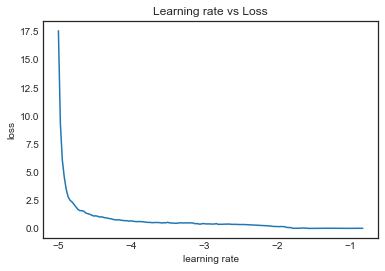

In [12]:
lrfinder.plot_schedule()

In [10]:
max_lr = 1e-3 / 2
lr_manager = OneCycleLR(lr_num_samples, 1, bs, max_lr,
                        end_percentage=0.1, scale_percentage=None,
                        maximum_momentum=0.95, minimum_momentum=0.85, verbose=True)

In [11]:
lr_callbacks = [lr_manager]
callbacks = model_callbacks + lr_callbacks

model.fit(x, y, epochs=1, validation_data=(val_x, val_y), callbacks=callbacks, steps_per_epoch=lr_steps, validation_steps=lr_steps)

Epoch 1/1
225/225 [==============================] - 216s 961ms/step - loss: 0.2572 - val_loss: 0.1746
